# U-Net for Autonomous Driving: Precision Image Segmentation

This project involves building a U-Net model, a type of convolutional neural network (CNN) designed for precise and efficient image segmentation. The model is applied to predict labels for each pixel in an image, specifically from a self-driving car dataset.

Semantic image segmentation is the primary task, where the goal is to label every pixel in an image with its corresponding class. Unlike object detection, which identifies objects using bounding boxes, semantic segmentation provides a pixel-perfect mask for each object. In this project, the "Car" class is marked with a dark blue mask, and the "Person" class is marked with a red mask:


Semantic image segmentation plays a crucial role in self-driving cars, as it allows the vehicle to understand its surroundings in detail, enabling it to navigate roads, avoid obstacles, and make real-time decisions to ensure safety.

<a name='1'></a>
## 1 - Importing Libraries

In [70]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

<a name='2'></a>
## 2 - Load and Split the Data

In [71]:
import os
import numpy as np 
import pandas as pd

import imageio.v2 as imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.

Text(0.5, 1.0, 'Segmentation')

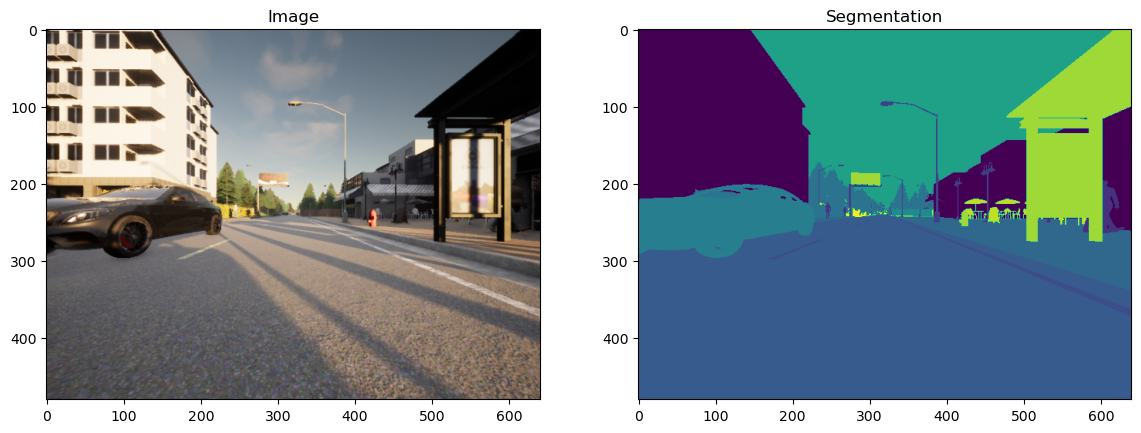

In [72]:
N = 4
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [73]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [74]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/003856.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/003856.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data


In [75]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3-1'></a>
### 3.1 - Model 


<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 


In [76]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 
                  (3,3),
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  (3,3),
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Downsampling Block) 


In [77]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 
                 (3,3),
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 
                 (3,3), 
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

<a name='3-4'></a>
### 3.4 - Build the Model



In [78]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)
    
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [79]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Model summary 

In [80]:
unet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 96, 128, 32)  896         ['input_8[0][0]']                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_66[0][0]']              
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 48, 64, 32)  0           ['conv2d_67[0][0]']        

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [81]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [82]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


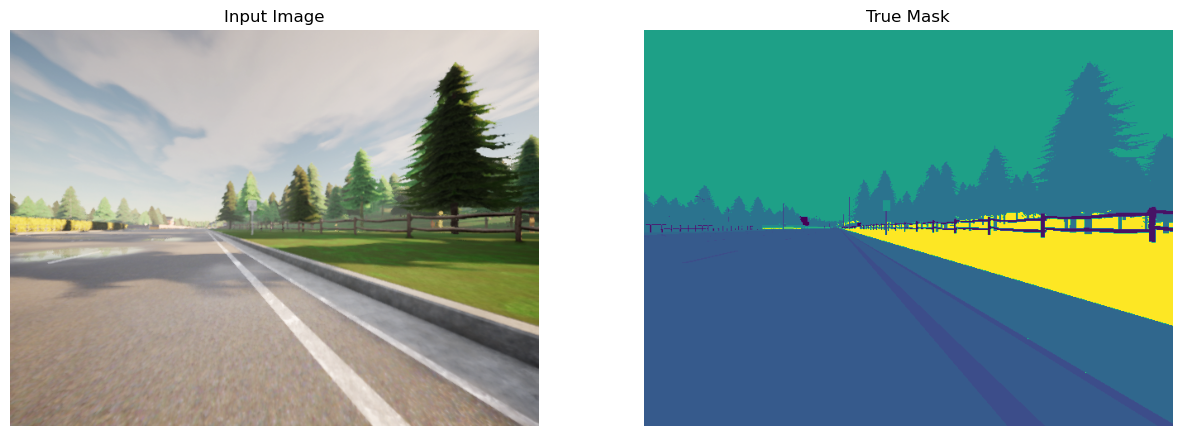

In [83]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


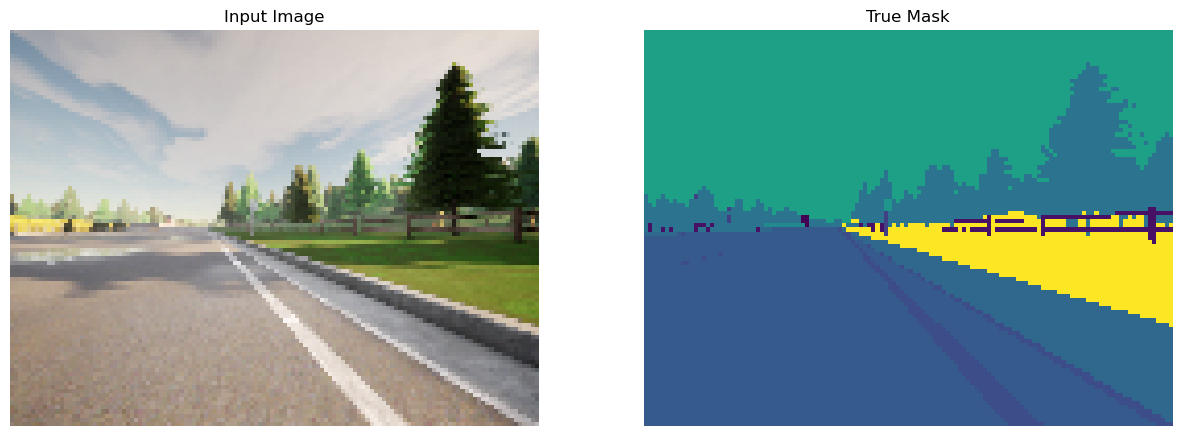

In [84]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 40s 1s/step - loss: 1.8788 - accuracy: 0.5234
Epoch 2/5
34/34 [==============================] - 28s 815ms/step - loss: 0.7616 - accuracy: 0.8079
Epoch 3/5
34/34 [==============================] - 28s 836ms/step - loss: 0.5451 - accuracy: 0.8405
Epoch 4/5
34/34 [==============================] - 28s 817ms/step - loss: 0.4305 - accuracy: 0.8715
Epoch 5/5
34/34 [==============================] - 25s 732ms/step - loss: 0.3839 - accuracy: 0.8830


<a name='4-1'></a>
### 4.1 - Create Predicted Masks 


In [86]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

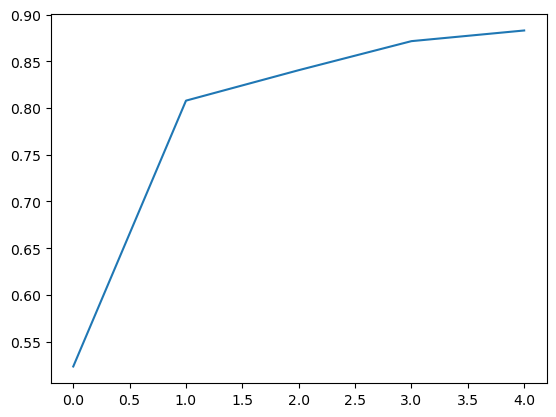

In [87]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Predictions 


In [88]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 425ms/step


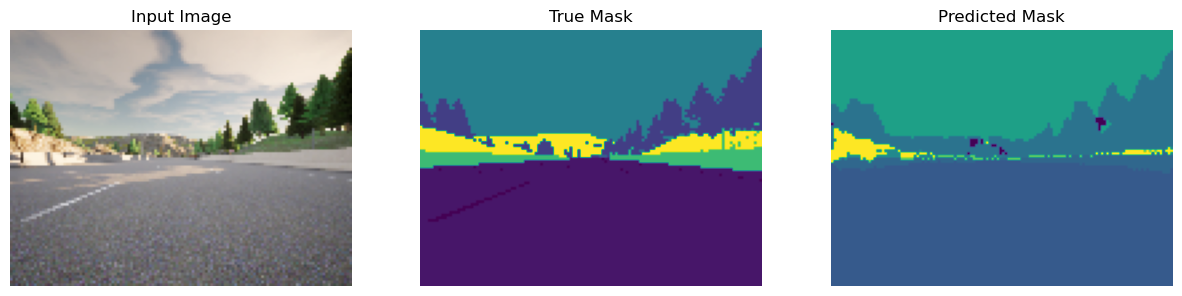

1/1 [==============================] - 0s 20ms/step


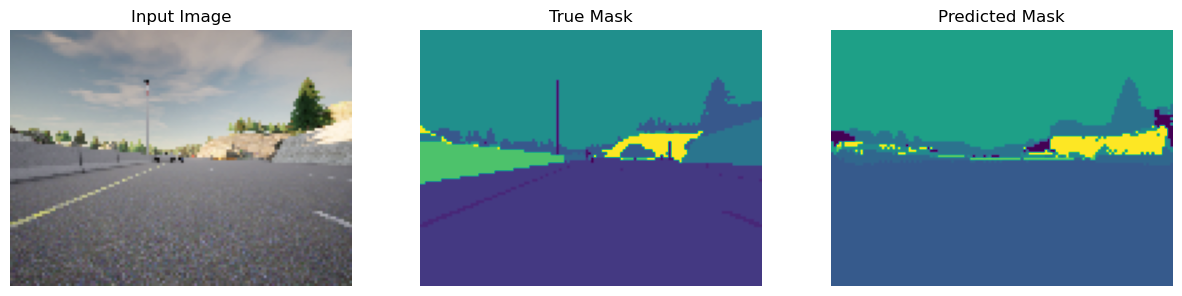

1/1 [==============================] - 0s 21ms/step


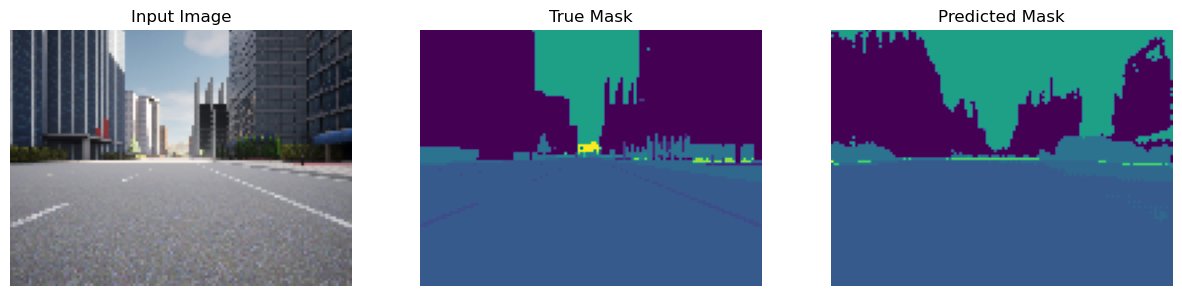

1/1 [==============================] - 0s 21ms/step


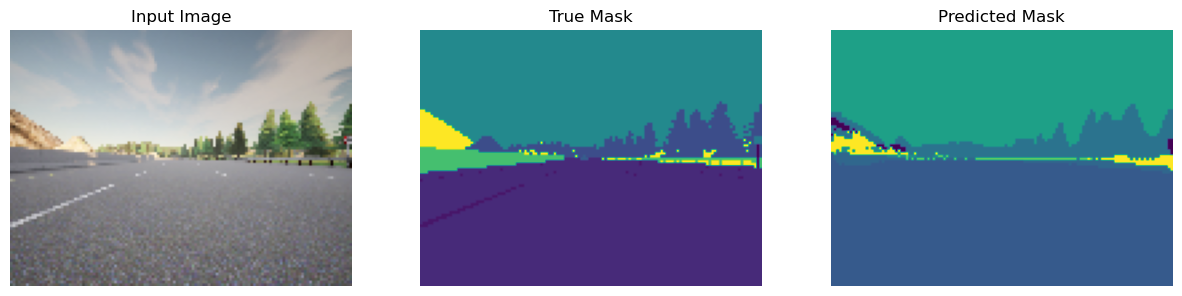

1/1 [==============================] - 0s 21ms/step


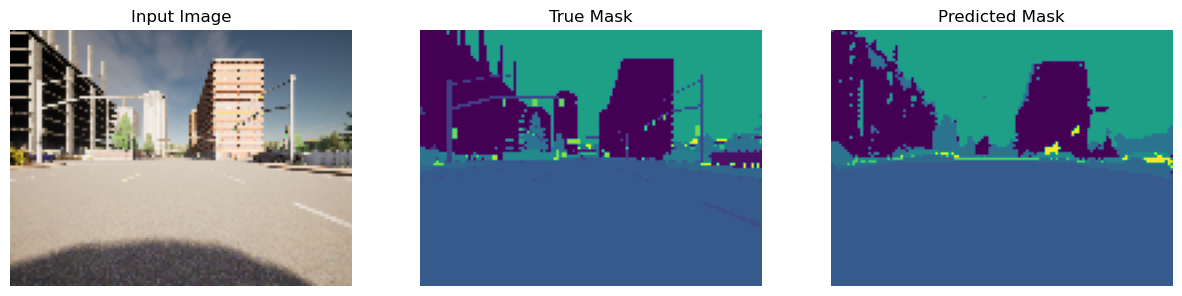

1/1 [==============================] - 0s 21ms/step


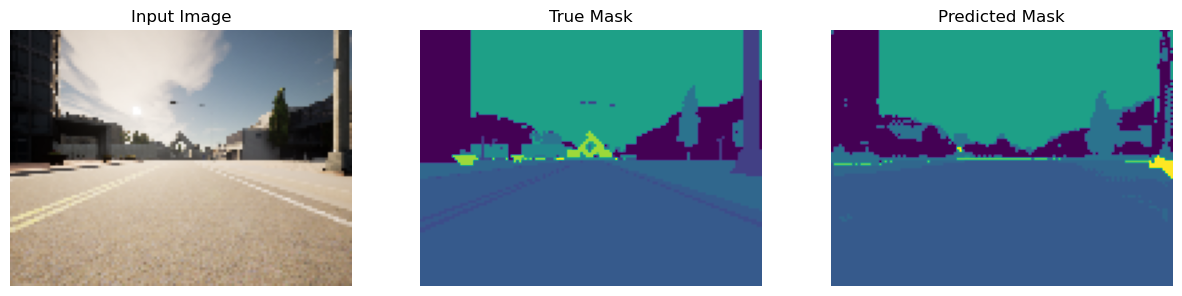

In [89]:
show_predictions(train_dataset, 6)